The Data Science problem is to predict whether a patient diagnosed with diabetes is likely to be readmitted within 30 days of discharge based on their clinical care data. Data set 1 contains information about the patient's lab results, medications, and hospital stay. The goal is to develop a model that can accurately predict the likelihood of readmission within 30 days.

In [ ]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, mannwhitneyu
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import io

In [ ]:
# load the data
df = pd.read_csv("diabetic_data.csv")

# first few rows of data
print(df.head())

   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No

In [ ]:
# describe data
print(df.describe())

       encounter_id   patient_nbr  admission_type_id  \
count  1.017660e+05  1.017660e+05      101766.000000   
mean   1.652016e+08  5.433040e+07           2.024006   
std    1.026403e+08  3.869636e+07           1.445403   
min    1.252200e+04  1.350000e+02           1.000000   
25%    8.496119e+07  2.341322e+07           1.000000   
50%    1.523890e+08  4.550514e+07           1.000000   
75%    2.302709e+08  8.754595e+07           3.000000   
max    4.438672e+08  1.895026e+08           8.000000   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count             101766.000000        101766.000000     101766.000000   
mean                   3.715642             5.754437          4.395987   
std                    5.280166             4.064081          2.985108   
min                    1.000000             1.000000          1.000000   
25%                    1.000000             1.000000          2.000000   
50%                    1.000000             7.00000

In [ ]:
# missing values
print(df.isnull().sum())

encounter_id                    0
patient_nbr                     0
race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                      0
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [ ]:
# dropping max_glu_serum and A1Cresult due to missing values
df.drop(columns=['max_glu_serum', 'A1Cresult'], inplace=True)

In [ ]:
# invalid values
df.replace('?', pd.NA, inplace=True)

In [ ]:
# outliers
numeric_columns = df.select_dtypes(include=['number']).columns
for col in numeric_columns:
    lower_cap = df[col].quantile(0.01)
    upper_cap = df[col].quantile(0.99)
    df[col] = df[col].clip(lower=lower_cap, upper=upper_cap)


###### Analyze the relationships between the various features and the diabetic outcomes

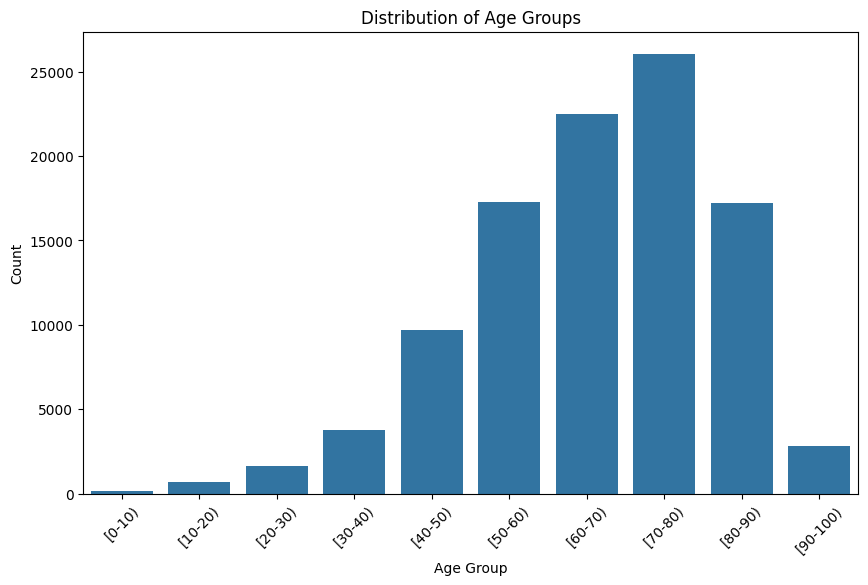

In [ ]:
# age groups
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='age')
plt.title('Distribution of Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

This bar graph displays the count of individuals in each age group within the dataset. The age group with the highest count was 70-80 years old, with approximately 25,000 individuals. It is clear that there is an increase in the count of individuals as the age groups progress from 0-10 to 70-80, followed by a decline in the older age groups 80-90 and 90-100. This is most likely due to the fact that hospital stays due to diabetes are most common for individuals between 70-80 years old.

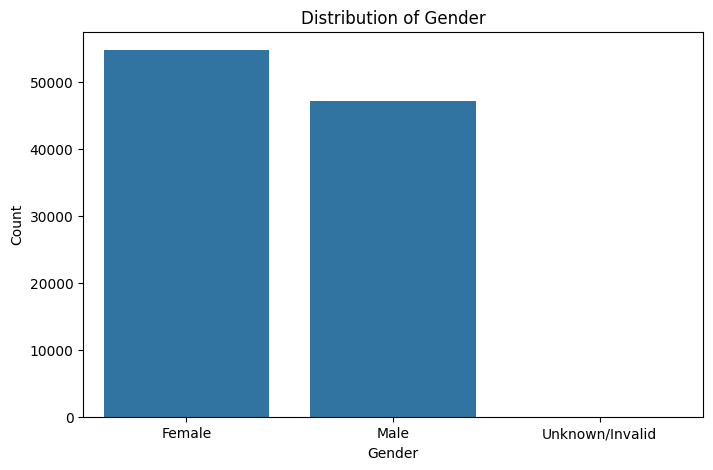

In [ ]:
# gender
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='gender')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

This bar graph displays the count of individuals by gender within the dataset. There are more females than males in th data set. The higher count of female individuals may indicate that healthcare providers should focus more on gender-specific treatments and interventions for women.

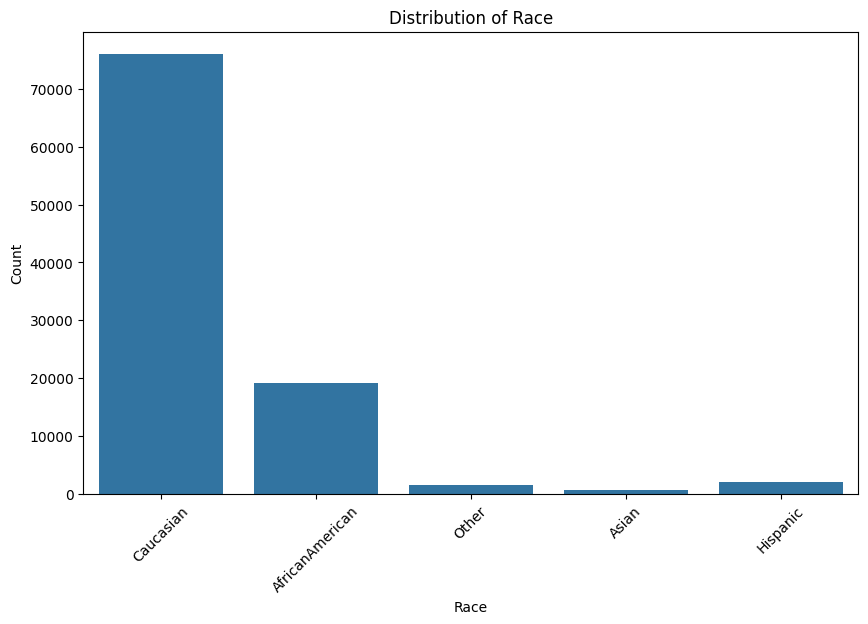

In [ ]:
# race
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='race')
plt.title('Distribution of Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

This bar graph displays the count of individuals by race within the dataset. Caucasian individuals take up the most data points in this data set. African American individuals have the next highest count, but still less than the Caucasian catagory by about 50,000 individuals. Asian, Hispanic, and 'other' catageories have significantly lower counts.

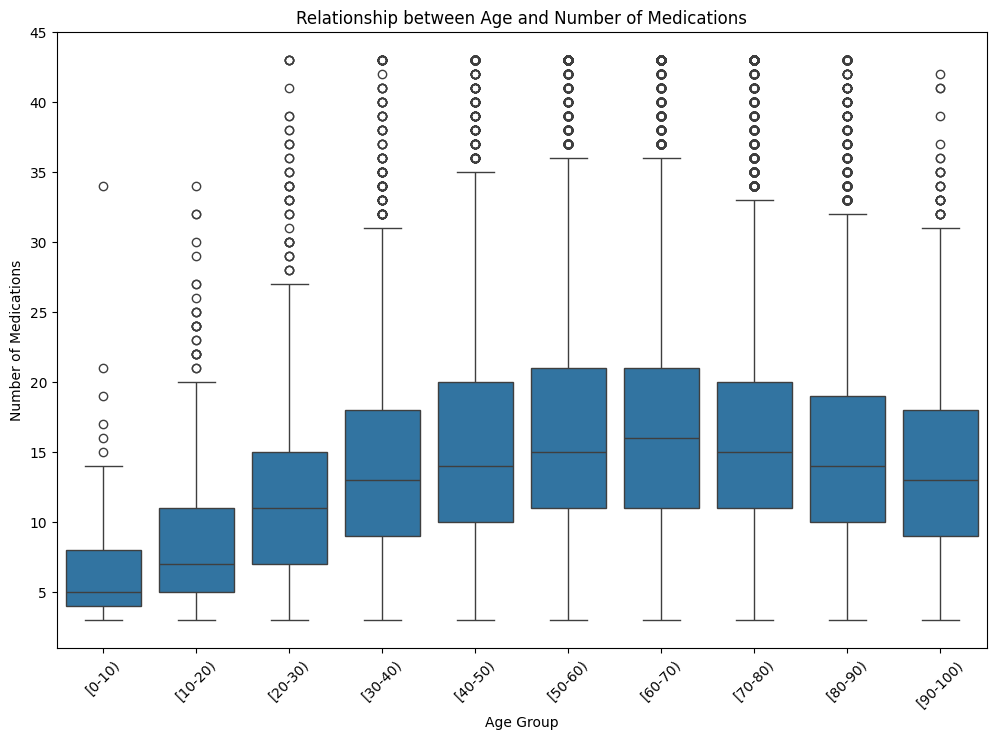

In [ ]:
# age vs number of medications
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='age', y='num_medications')
plt.title('Relationship between Age and Number of Medications')
plt.xlabel('Age Group')
plt.ylabel('Number of Medications')
plt.xticks(rotation=45)
plt.show()

This box plot shows the distribution of the number of medications taken by individuals within each age group. The median number of medications tends to increase with age, indicating that older individuals generally take more medications. The IQR tends to be wider for older age groups, indicating more variability in the number of medications taken. There are more outliers in the older age groups, suggesting that some individuals take significantly more medications than others in the same age group. This box plot shows that as individuals age, they tend to take more medications, which is expected due to the increased prevalence of chronic conditions and comorbidities in older adults.

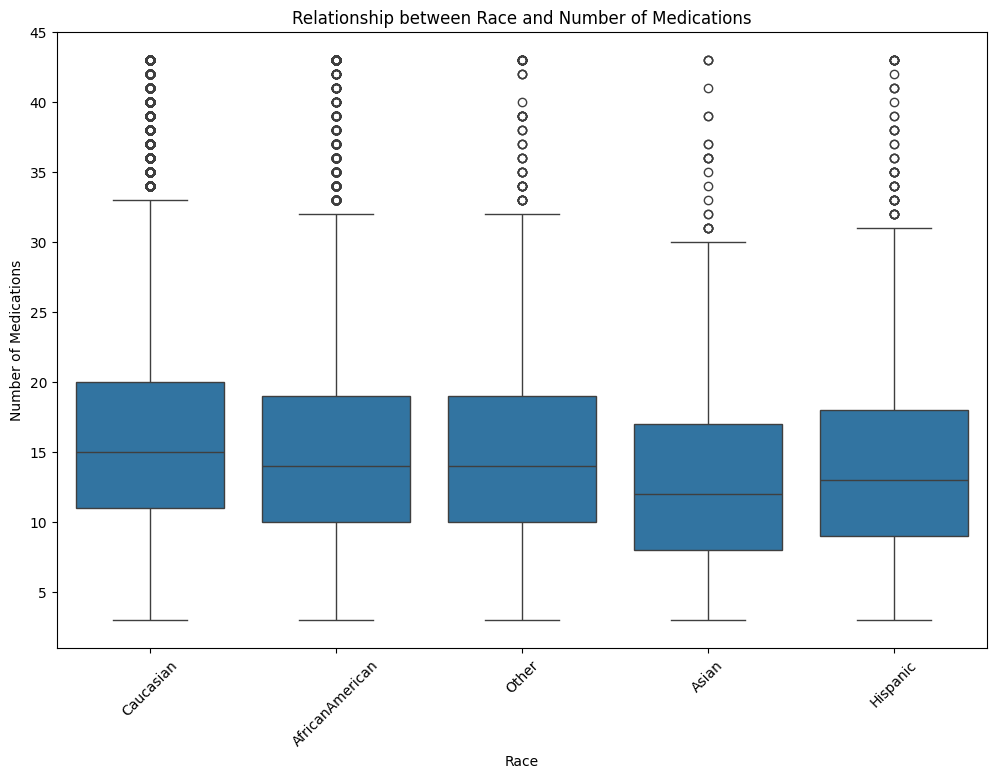

In [ ]:
# race vs number of medications
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='race', y='num_medications')
plt.title('Relationship between Race and Number of Medications')
plt.xlabel('Race')
plt.ylabel('Number of Medications')
plt.xticks(rotation=45)
plt.show()

This box plot displays the distribution of the number of medications taken by individuals within each race category. The median number of medications varies across race categories. Caucasian and African American individuals tend to have higher median values compared to Asian and Hispanic individuals. The IQR is wider for Caucasian and AfricanAmerican categories, indicating more variability in the number of medications taken. There are more outliers in the Caucasian and AfricanAmerican categories, suggesting that some individuals take significantly more medications than others in the same race category.

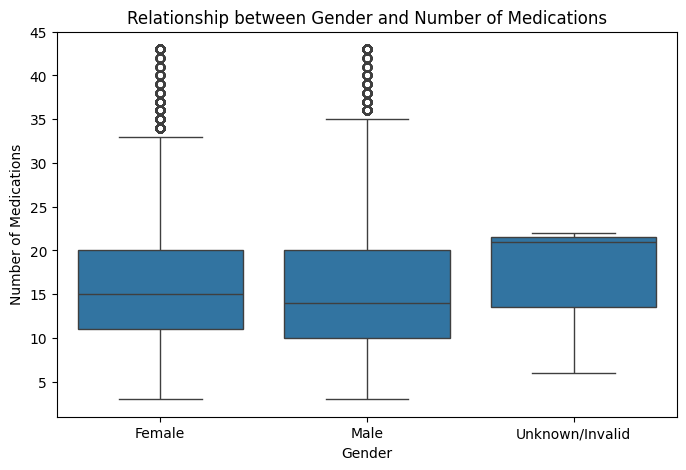

In [ ]:
# gender vs number of medications
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='gender', y='num_medications')
plt.title('Relationship between Gender and Number of Medications')
plt.xlabel('Gender')
plt.ylabel('Number of Medications')
plt.show()

This box plot shows the distribution of the number of medications taken by individuals within each gender category. The median number of medications is similar for both Female and Male categories. The IQR is slightly wider for the Female category, indicating more variability in the number of medications taken by females.

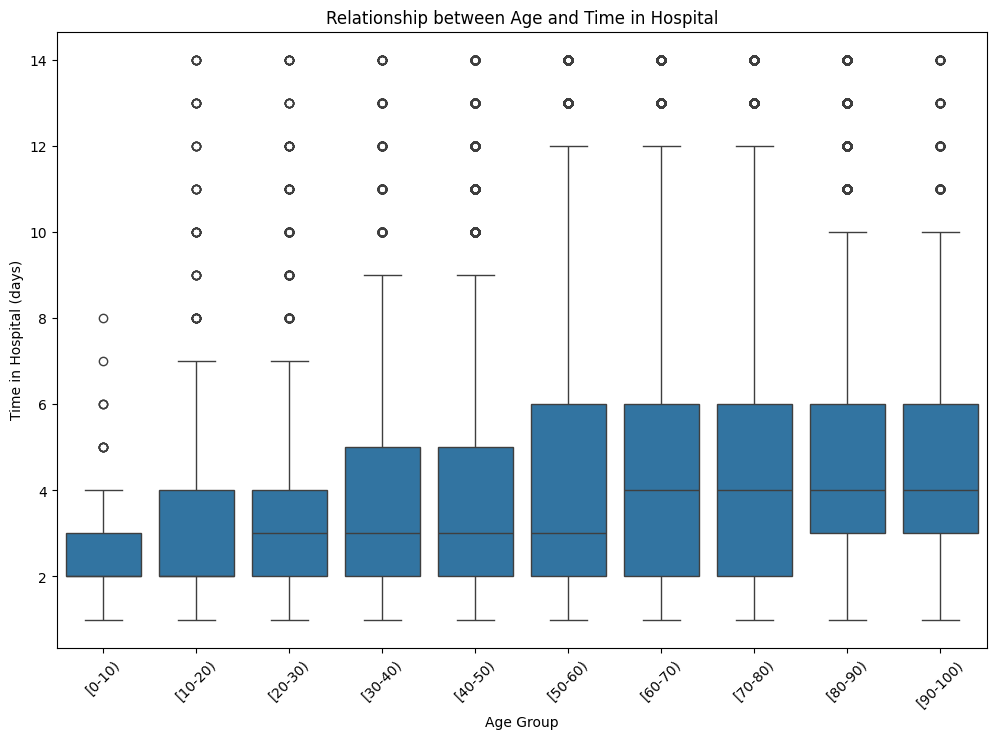

In [ ]:
# age vs time in hospital
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='age', y='time_in_hospital')
plt.title('Relationship between Age and Time in Hospital')
plt.xlabel('Age Group')
plt.ylabel('Time in Hospital (days)')
plt.xticks(rotation=45)
plt.show()

This box plot shows the distribution of the time spent in the hospital by individuals within each age group. The median time spent in the hospital is  consistent across age groups. The IQR is narrow for most age groups.

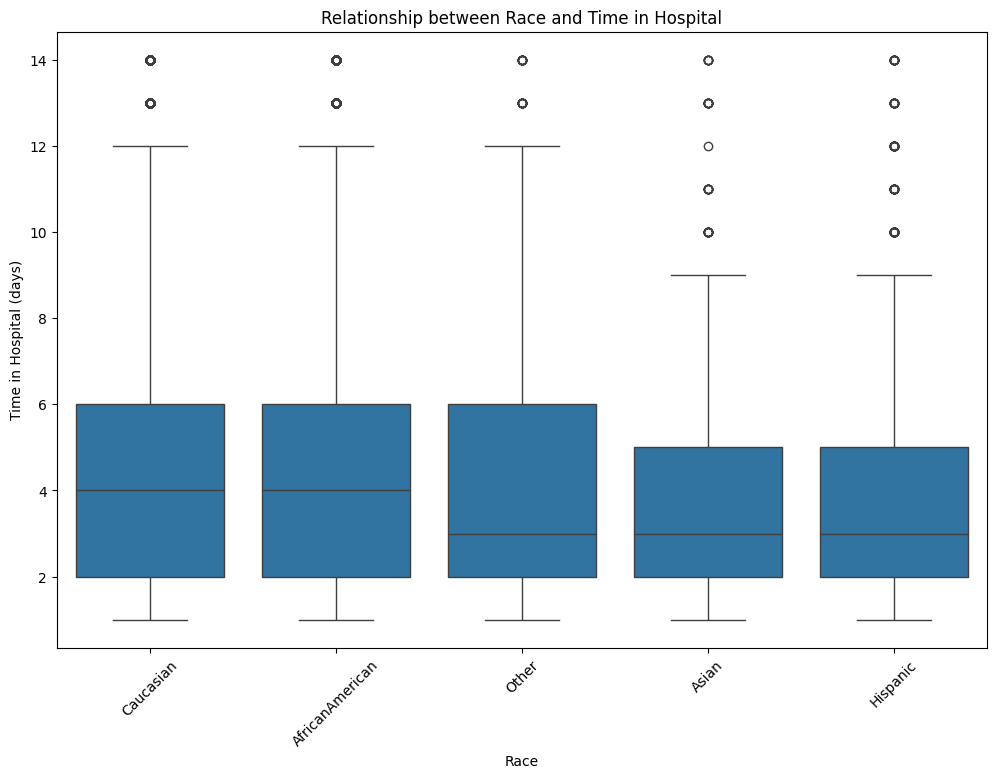

In [ ]:
# race vs time in hospital
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='race', y='time_in_hospital')
plt.title('Relationship between Race and Time in Hospital')
plt.xlabel('Race')
plt.ylabel('Time in Hospital (days)')
plt.xticks(rotation=45)
plt.show()

The box plot shows the distribution of the time spent in the hospital by individuals within each race category. The median time spent in the hospital is consistent across race categories. The IQR is narrow for most race categories.

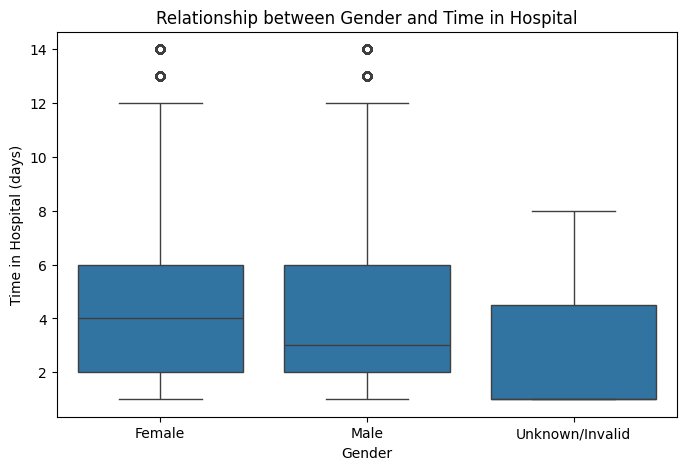

In [ ]:
# gender vs time in hospital
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='gender', y='time_in_hospital')
plt.title('Relationship between Gender and Time in Hospital')
plt.xlabel('Gender')
plt.ylabel('Time in Hospital (days)')
plt.show()

The box plot shows the distribution of the time spent in the hospital by individuals within each gender category. The median time spent in the hospital is similar for both Female and Male categories. The IQR is narrow for both Female and Male categories.


###### Validate that the patterns we detected are statistically meaningful and not noise.

In [ ]:
# Pattern 1: Gender vs Readmission (Chi-Square)
gender_readmit = pd.crosstab(df['gender'], df['readmitted'])
_, p_gender, _, _ = chi2_contingency(gender_readmit)

# Pattern 2: Age group vs Time in Hospital (ANOVA)
age_time_data = df[['age', 'time_in_hospital']].dropna()
age_groups = [group['time_in_hospital'].values for name, group in age_time_data.groupby('age')]
_, p_age = f_oneway(*age_groups)

# Pattern 3: Number of inpatient visits vs Readmission (Mann-Whitney U)
df['readmit_binary'] = df['readmitted'].apply(lambda x: 'NO' if x == 'NO' else 'YES')
inpatient_yes = df[df['readmit_binary'] == 'YES']['number_inpatient']
inpatient_no = df[df['readmit_binary'] == 'NO']['number_inpatient']
_, p_inpatient = mannwhitneyu(inpatient_yes, inpatient_no, alternative='two-sided')

# Print p-values
print("P-value for Gender vs Readmission:", p_gender)
print("P-value for Age vs Time in Hospital:", p_age)
print("P-value for Inpatient Visits vs Readmission:", p_inpatient)

# --- Feature Selection for ML ---

# Drop unhelpful columns
df_ml = df.drop(columns=[
    'encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty',
    'diag_1', 'diag_2', 'diag_3', 'readmitted'
])
df_ml = df_ml[df_ml['readmit_binary'].notna()]
target = df_ml['readmit_binary'].map({'NO': 0, 'YES': 1})

# Label encode categorical features
label_encoded_df = df_ml.copy()
for col in label_encoded_df.select_dtypes(include='object').columns:
    label_encoded_df[col] = LabelEncoder().fit_transform(label_encoded_df[col].astype(str))

# Select top 10 features
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(label_encoded_df.drop(columns=['readmit_binary']), target)
top_features = label_encoded_df.drop(columns=['readmit_binary']).columns[selector.get_support()].tolist()

print("Top features for ML modeling:", top_features)

P-value for Gender vs Readmission: 1.447272318868805e-07
P-value for Age vs Time in Hospital: 3.7624528208977174e-257
P-value for Inpatient Visits vs Readmission: 0.0
Top features for ML modeling: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'change', 'diabetesMed']


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [29 30] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


###### Patterns: Gender vs. Readmission
###### Test Used: Chi-Square Test of Independence
###### p-value: 1.45 × 10⁻⁷
###### Interpretation: This result indicates a statistically significant association between gender and hospital readmission status. Although the effect size isn’t shown here, the small p-value suggests gender differences should be considered in predictive modeling.

###### Patterns: Age Group vs. Time in Hospital
###### Test Used: One-Way ANOVA
###### p-value: 3.76 × 10⁻²⁵⁷
###### Interpretation: Extremely low p-value confirms that the average time spent in the hospital significantly varies by age group. Older patients tend to stay longer, which could reflect more complex health needs.

###### Patterns: Number of Inpatient Visits vs. Readmission
###### Test Used: Mann-Whitney U Test
###### p-value: 0.0 (effectively < 1e-300)
###### Interpretation: The number of prior inpatient visits is significantly higher among patients who are readmitted. This aligns with expectations that patients with more frequent hospitalizations are at greater risk of returning.


###### The following are the features selected for ML along with the reason why
###### time_in_hospital	Direct measure of resource usage; statistically linked to age and readmission.
###### num_lab_procedures	Reflects medical complexity; more procedures may imply worse health conditions.
###### num_medications	Captures treatment intensity, which can signal severity.
###### number_inpatient	Strongest predictor of readmission (statistically significant).
###### number_diagnoses	Indicates case complexity and comorbidities.
###### change	Whether there was a medication change; categorical and easy to encode.
###### diabetesMed	Whether the patient was prescribed diabetes medication; simple binary feature.
###### age	Strongly associated with hospital stay; already in clean categorical brackets.
###### gender	Statistically significant effect on readmission; binary and easy to encode.

In [ ]:
# Feature engineer: high_utilization
df['high_utilization'] = (
    df[['number_inpatient', 'number_outpatient', 'number_emergency']]
    .astype(float)
    .sum(axis=1) > 2
)

# Drop missing readmission values
df_valid = df.dropna(subset=['readmit_binary', 'high_utilization'])

# Chi-Square test between high_utilization and readmission
contingency_table = pd.crosstab(df_valid['high_utilization'], df_valid['readmit_binary'])
_, p_value, _, _ = chi2_contingency(contingency_table)

print("P-value for high_utilization vs. readmission:", round(p_value, 2))


P-value for high_utilization vs. readmission: 0.0


We created a new feature called high_utilization, which identifies patients who had more than two combined inpatient, outpatient, and emergency visits. This is intended to capture patients who have a history of high interaction with the healthcare system — a pattern often associated with chronic conditions or complications.

We then performed a Chi-Square Test of Independence to evaluate whether this new feature is statistically associated with the readmission outcome.

p-value = 0.00 (rounded to two decimal places)

This extremely low p-value provides strong statistical evidence that there is a significant association between being a high-utilization patient and the likelihood of being readmitted. In other words, patients with more prior hospital visits are much more likely to return within 30 days or later.

In [ ]:
features = [
    'age', 'gender', 'time_in_hospital', 'num_lab_procedures', 'num_medications',
    'number_inpatient', 'number_diagnoses', 'change', 'diabetesMed', 'high_utilization'
]
df_model = df[features + ['readmit_binary']].dropna()

# Define X and y
X = df_model[features]
y = df_model['readmit_binary'].map({'NO': 0, 'YES': 1})

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Identify column types
categorical_features = ['age', 'gender', 'change', 'diabetesMed', 'high_utilization']
numeric_features = ['time_in_hospital', 'num_lab_procedures', 'num_medications',
                    'number_inpatient', 'number_diagnoses']

# Preprocessing pipelines
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine transformers
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_features),
    ('num', numeric_transformer, numeric_features)
])

# Fit on train and transform both sets
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Train shape:", X_train_processed.shape)
print("Test shape:", X_test_processed.shape)

Train shape: (81412, 24)
Test shape: (20354, 24)


The data was successfully split into a training set with 81,412 rows and a test set with 20,354 rows. After encoding categorical variables and normalizing numeric ones, each row was transformed into 24 numerical features, ready for machine learning modeling.










###### Build the ML model that predicts the target variable based on the selected features.

In [ ]:
df_model = df_model[df_model['gender'] != 'Unknown/Invalid']
df_model['age'] = df_model['age'].astype(str).str.strip()


age_map = {
    '[0-10)': 1, '[10-20)': 2, '[20-30)': 3, '[30-40)': 4,
    '[40-50)': 5, '[50-60)': 6, '[60-70)': 7, '[70-80)': 8,
    '[80-90)': 9, '[90-100)': 10
}
df_model['age'] = df_model['age'].map(age_map)
df_model['gender'] = df_model['gender'].map({'Male': 1, 'Female': 0})
df_model['change'] = df_model['change'].map({'No': 0, 'Ch': 1})
df_model['diabetesMed'] = df_model['diabetesMed'].map({'No': 0, 'Yes': 1})

df_model['high_utilization'] = df_model['high_utilization'].astype(int)
df_model['readmit_binary'] = df_model['readmit_binary'].map({'NO': 0, 'YES': 1})

In [ ]:
# Model 1: Random Forest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df_model[features]
y = df_model['readmit_binary']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_leaf=3,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Evaluate base model
train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)
print(f"\nTraining accuracy: {train_score:.2f}")
print(f"Test accuracy: {test_score:.2f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature importance:")
print(feature_importance.round(2))

# GridSearchCV with optimized parameter grid
rf_grid = RandomForestClassifier(
    random_state=42,
    class_weight='balanced_subsample',
    n_jobs=-1
)

# Refined parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [8, 15],
    'min_samples_leaf': [3],
    'min_samples_split': [5]
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf_grid,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring='balanced_accuracy'
)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_.round(2))

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\nBest model classification report:")
print(classification_report(y_test, y_pred))


Training accuracy: 0.63
Test accuracy: 0.62

Feature importance:
              feature  importance
5    number_inpatient        0.41
9    high_utilization        0.21
6    number_diagnoses        0.11
4     num_medications        0.07
0                 age        0.06
3  num_lab_procedures        0.05
2    time_in_hospital        0.04
8         diabetesMed        0.03
7              change        0.01
1              gender        0.01
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters: {'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.61

Best model classification report:
              precision    recall  f1-score   support

           0       0.63      0.74      0.68     11016
           1       0.61      0.49      0.54      9337

    accuracy                           0.62     20353
   macro avg       0.62      0.61      0.61     20353
weighted avg       0.62      0.62      0.62     20353



In [ ]:
# Model 2： Gradient Boosting Model
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(
    random_state=42,
    subsample=0.8,
    max_features='sqrt',
    validation_fraction=0.2
)

param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1],
    'max_depth': [5, 6],
    'min_samples_split': [10]
}


unique_classes = np.unique(y_train)
n_classes = len(unique_classes)
n_samples = len(y_train)
weights = np.zeros(n_samples)

for idx, label in enumerate(unique_classes):
    class_mask = (y_train == label)
    n_samples_class = np.sum(class_mask)
    weights[class_mask] = n_samples / (n_classes * n_samples_class)

grid_gb = GridSearchCV(
    gb,
    param_grid_gb,
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring='balanced_accuracy'
)
grid_gb.fit(X_train, y_train, sample_weight=weights)


print("Best Parameters:", grid_gb.best_params_)
print(f"Best Score: {grid_gb.best_score_:.2f}")


print("\nGradient Boosting Classification Report:")
y_pred_gb = grid_gb.predict(X_test)
print(classification_report(y_test, y_pred_gb, zero_division=1))

print("\nPrediction distribution:")
for label in sorted(set(y_pred_gb)):
    print(f"Class {label}: {(y_pred_gb == label).sum()} predictions")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100}
Best Score: 0.61

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65     11016
           1       0.59      0.56      0.57      9337

    accuracy                           0.62     20353
   macro avg       0.61      0.61      0.61     20353
weighted avg       0.62      0.62      0.62     20353


Prediction distribution:
Class 0: 11362 predictions
Class 1: 8991 predictions


In [ ]:
# Model 3: k-Nearest Neighbors

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


knn = KNeighborsClassifier(
    n_jobs=-1,
    weights='distance'
)

param_grid_knn = {
    'n_neighbors': [30, 40],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(
    knn,
    param_grid_knn,
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring='balanced_accuracy'
)

grid_knn.fit(X_train_scaled, y_train)


print("Best Parameters:", grid_knn.best_params_)
print(f"Best Score: {grid_knn.best_score_:.2f}")

# Evaluate best model
y_pred_knn = grid_knn.predict(X_test_scaled)
print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn, zero_division=1))

# Print prediction distribution
print("\nPrediction distribution:")
for label in sorted(set(y_pred_knn)):
    print(f"Class {label}: {(y_pred_knn == label).sum()} predictions")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 40, 'weights': 'uniform'}
Best Score: 0.59

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.75      0.68     11016
           1       0.60      0.44      0.51      9337

    accuracy                           0.61     20353
   macro avg       0.61      0.60      0.59     20353
weighted avg       0.61      0.61      0.60     20353


Prediction distribution:
Class 0: 13526 predictions
Class 1: 6827 predictions


##Question 7

Analyze the evaluated models. For each algorithm, ensure that you:
Display: 1) the best model and 2) the best score that was obtained.
Evaluate the scores from GridSearchCV for the training set and the test set to diagnose any bias-variance problems. Comment on the quality of the model.
NOTE: seeing that you are analyzing healthcare data, ensure that you discuss what is the desired metric to evaluate the results based on the machine learning task e.g. accuracy, precision, recall, f1-score, MSE, R2, etc.


The bese models and scores were displayed in the results of question 6.
### Model 1: Random Forest

**Best Model Classification Report**:

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.63      | 0.74   | 0.68     | 11016   |
| 1     | 0.61      | 0.49   | 0.54     | 9337    |

**Overall Metrics**:

- **Accuracy**: 0.62  
- **Macro Avg**: Precision: 0.62 | Recall: 0.61 | F1-Score: 0.61  
- **Weighted Avg**: Precision: 0.62 | Recall: 0.62 | F1-Score: 0.62  
- **Total Samples**: 20,353

**Best Cross Validation Score:** 0.61


### Model 2: Gradient Boosting Model

**Best Model Classification Report**:

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.64      | 0.66   | 0.65     | 11016   |
| 1     | 0.59      | 0.56   | 0.57     | 9337    |

**Overall Metrics**:

- **Accuracy**: 0.62  
- **Macro Avg**: Precision: 0.61 | Recall: 0.61 | F1-Score: 0.61  
- **Weighted Avg**: Precision: 0.62 | Recall: 0.62 | F1-Score: 0.62  
- **Total Samples**: 20,353

**Best Cross Validation Score:** 0.61

### Model 3: k-Nearest Neighbors

**Best Model Classification Report**:

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.61      | 0.75   | 0.68     | 11016   |
| 1     | 0.60      | 0.44   | 0.51     | 9337    |

**Overall Metrics**:

- **Accuracy**: 0.61  
- **Macro Avg**: Precision: 0.61 | Recall: 0.60 | F1-Score: 0.59  
- **Weighted Avg**: Precision: 0.61 | Recall: 0.61 | F1-Score: 0.60  
- **Total Samples**: 20,353

**Best Cross Validation Score:** 0.59

For Model 1, the balanced training and test accuracy (0.63 vs. 0.62) suggests low variance and minimal overfitting. Overall, the model generalizes reasonably well.
For Model 2, the model performs similarly to Model 1. However, the model has a slightly better F1-score for class 1, suggesting it has slightly better balance and generalization.
For Model 3, the model has lower CV and test scores which suggest that it has mild underfitting due to a high k value (40).

For healthcare data, the recall and F1-score for the positive class (class 1) are the desired metrics to evaluate the results. Since the models aim to detect individuals who may be at risk, false negatives are more harmful than false positives.

In conclusion, all models are reasonably balanced with no significant overfitting, however the best overall model is Gradient Boosting because it has a higher recall and F1-score for the positive class.

In [ ]:
df_eval = X_test.copy()
df_eval['actual'] = y_test.values
df_eval['predicted'] = y_pred
df_eval['age'] = df_model.loc[df_eval.index, 'age'].values
df_eval['gender'] = df_model.loc[df_eval.index, 'gender'].values

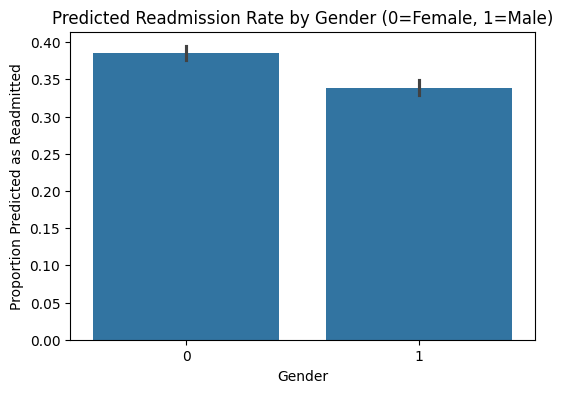

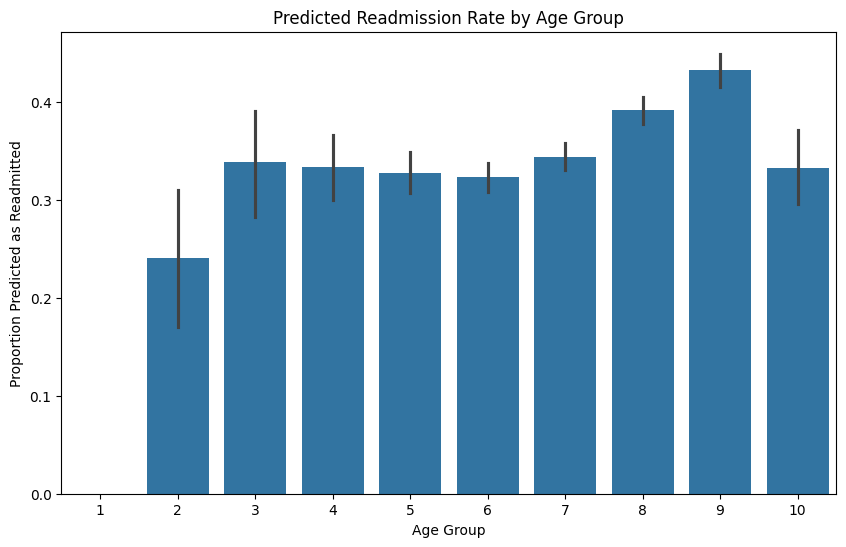

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(data=df_eval, x='gender', y='predicted')
plt.title('Predicted Readmission Rate by Gender (0=Female, 1=Male)')
plt.ylabel('Proportion Predicted as Readmitted')
plt.xlabel('Gender')
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(data=df_eval, x='age', y='predicted')
plt.title('Predicted Readmission Rate by Age Group')
plt.ylabel('Proportion Predicted as Readmitted')
plt.xlabel('Age Group')
plt.show()

In [ ]:
def compute_group_metrics(df, group_col):
    group_stats = []

    for g in sorted(df[group_col].unique()):
        subset = df[df[group_col] == g]
        report = classification_report(subset['actual'], subset['predicted'], output_dict=True, zero_division=0)
        group_stats.append({
            group_col: g,
            'precision': report['1']['precision'],
            'recall': report['1']['recall'],
            'f1_score': report['1']['f1-score'],
            'support': report['1']['support']
        })

    return pd.DataFrame(group_stats)

gender_bias_df = compute_group_metrics(df_eval, 'gender')
age_bias_df = compute_group_metrics(df_eval, 'age')

print("Gender Group Metrics:")
print(gender_bias_df.round(3))

print("\nAge Group Metrics:")
print(age_bias_df.round(3))


Gender Group Metrics:
   gender  precision  recall  f1_score  support
0       0      0.614   0.507     0.555   5120.0
1       1      0.609   0.460     0.524   4217.0

Age Group Metrics:
   age  precision  recall  f1_score  support
0    1      0.000   0.000     0.000      5.0
1    2      0.581   0.383     0.462     47.0
2    3      0.745   0.539     0.626    152.0
3    4      0.669   0.533     0.593    319.0
4    5      0.689   0.498     0.578    853.0
5    6      0.631   0.463     0.534   1563.0
6    7      0.637   0.468     0.540   2143.0
7    8      0.587   0.489     0.533   2374.0
8    9      0.567   0.520     0.542   1647.0
9   10      0.508   0.406     0.451    234.0


From our visiualizations we find that precision is similar between genders, meaning model is equally accurate in positive predictions.
However, recall is lower for males, meaning the model misses more true readmissions in male patients. In additon, the F1-score is also lower for males, indicating slightly worse balance between precision and recall.

For age, we find that the model performs best on younger adults (ages 20-50), with the highest F1-scores in groups 3–5. However, the model's performance declines for elderly groups (especially 90–100), where both precision and recall drop. In addition, age group 1 (0–10) is statistically irrelevant due to low support (5 samples).

Gender Bias: The model is less sensitive to readmissions in male patients, potentially leading to under-intervention.

Age Bias: Predictive power drops for elderly patients. This could reflect underfitting for older individuals or insufficient age-related features.

Data imbalance: Groups with very low sample sizes introduce noise and instability in metrics.

